# Test problem

In [8]:
using Plots, SparseArrays, Revise, Krylov
includet("nonuniformMultiGrid.jl")
includet("constructions2D.jl")
includet("grid_constructions1D.jl")
includet("grid_constructions2D.jl")
includet("linespacecs.jl")
includet("MG_preconditioner.jl")

In [9]:
n = 2^7
grid,m = linspacecs(0,1,n+1,pi/6)
f = pointsource_half2D(2*n)
σ = float(-10)
sigmas = spdiagm(σ*ones(length(grid)^2))
H = helmholtz2D(grid,sigmas);
sol = H \ f;

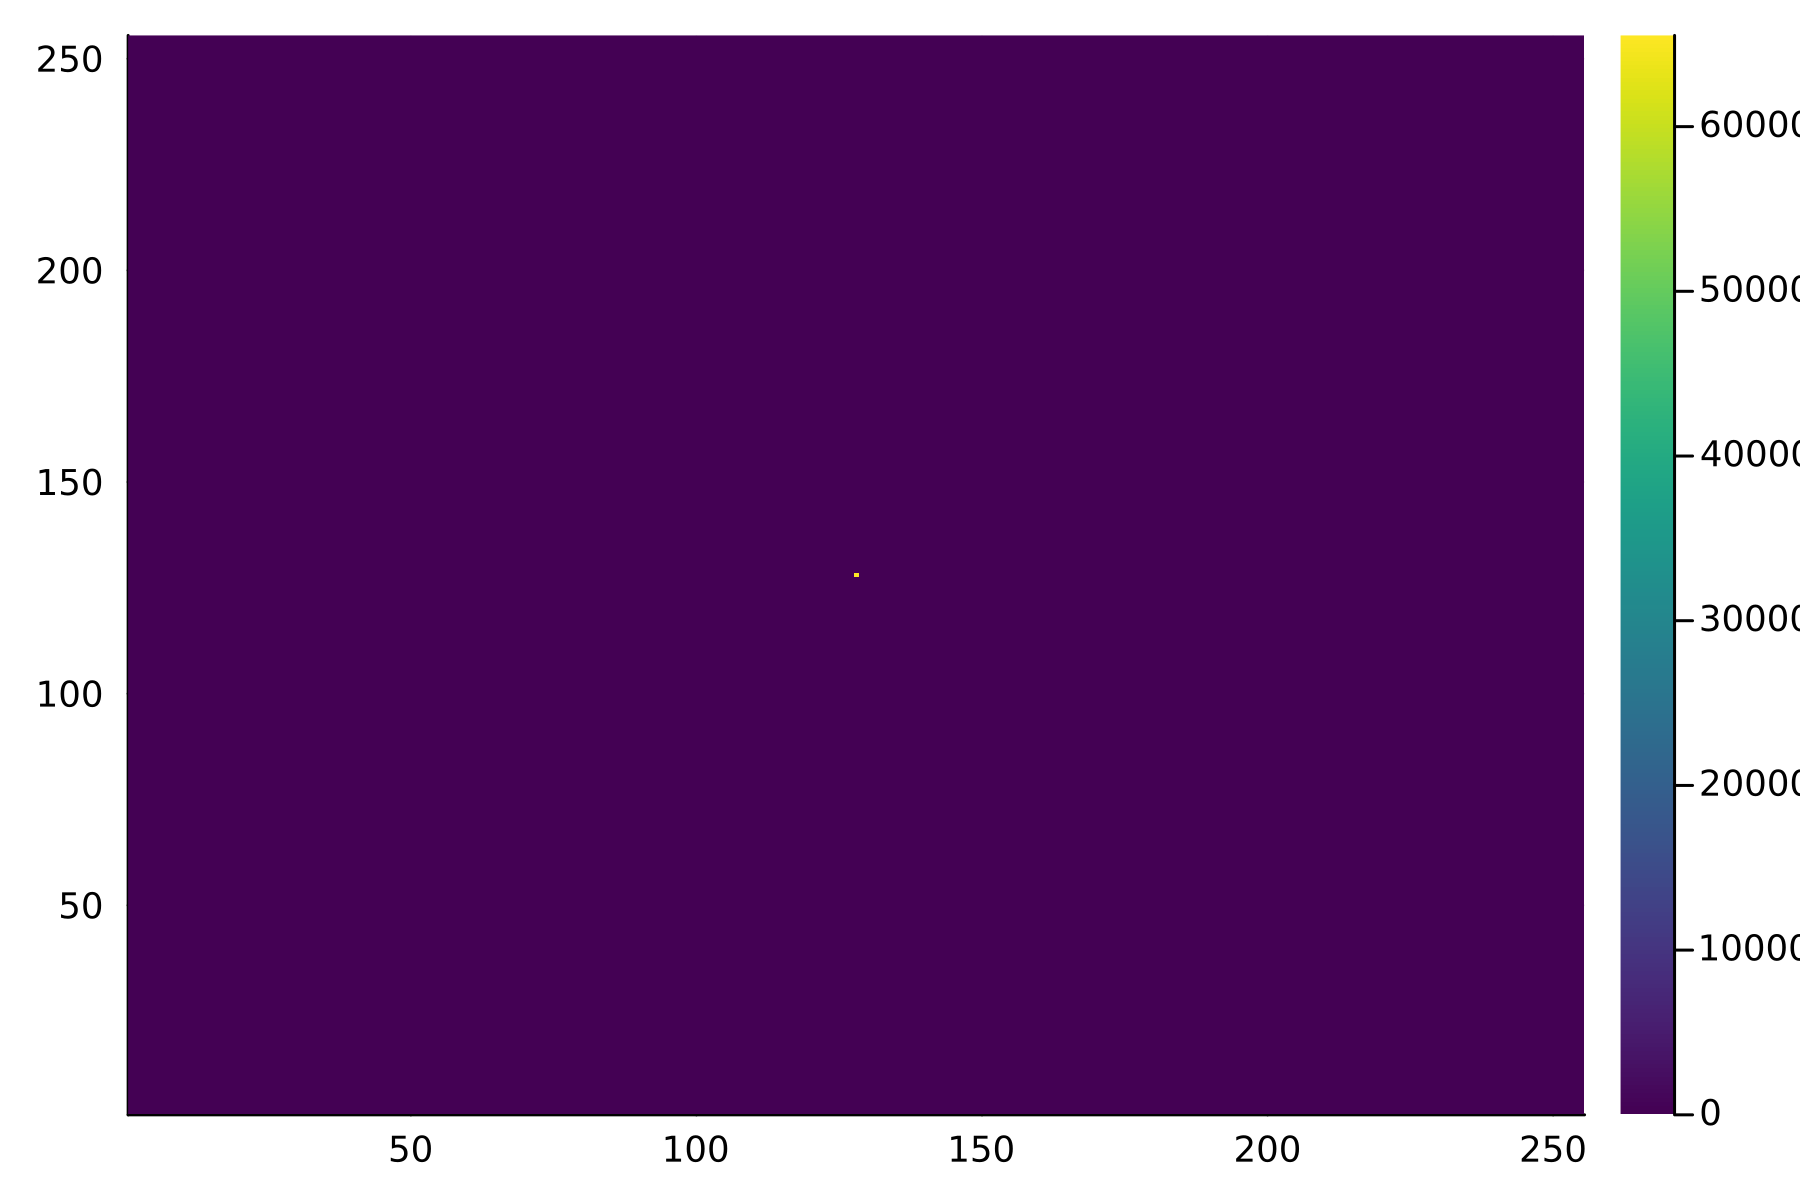

In [10]:
heatmap(reshape(real(f),2n-1,2n-1),color=:viridis)

In [11]:
u = zeros(length(f))
errors = Float64[]
us = []
for _ in 1:20
    u = nonUniformVcycle2D(
        grid=grid,
        A=H,
        f=f,
        u=u,
        nu1=3,
        nu2=3,
        recursion_depth=50)
    error = norm(sol - u)
    push!(errors, error)
    push!(us, u)
end


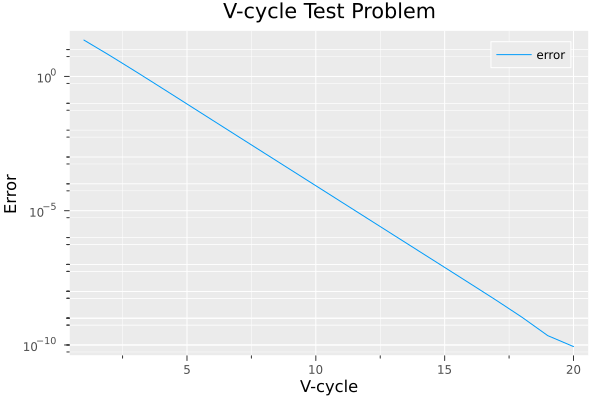

In [12]:
theme(:ggplot2)
p = plot(errors, title="V-cycle Test Problem", label="error", xlabel="V-cycle", ylabel="Error", yscale=:log10)

# Save the plot
savefig(p,"../plots/Vcycle_Test_Problem.pdf")
display(p)

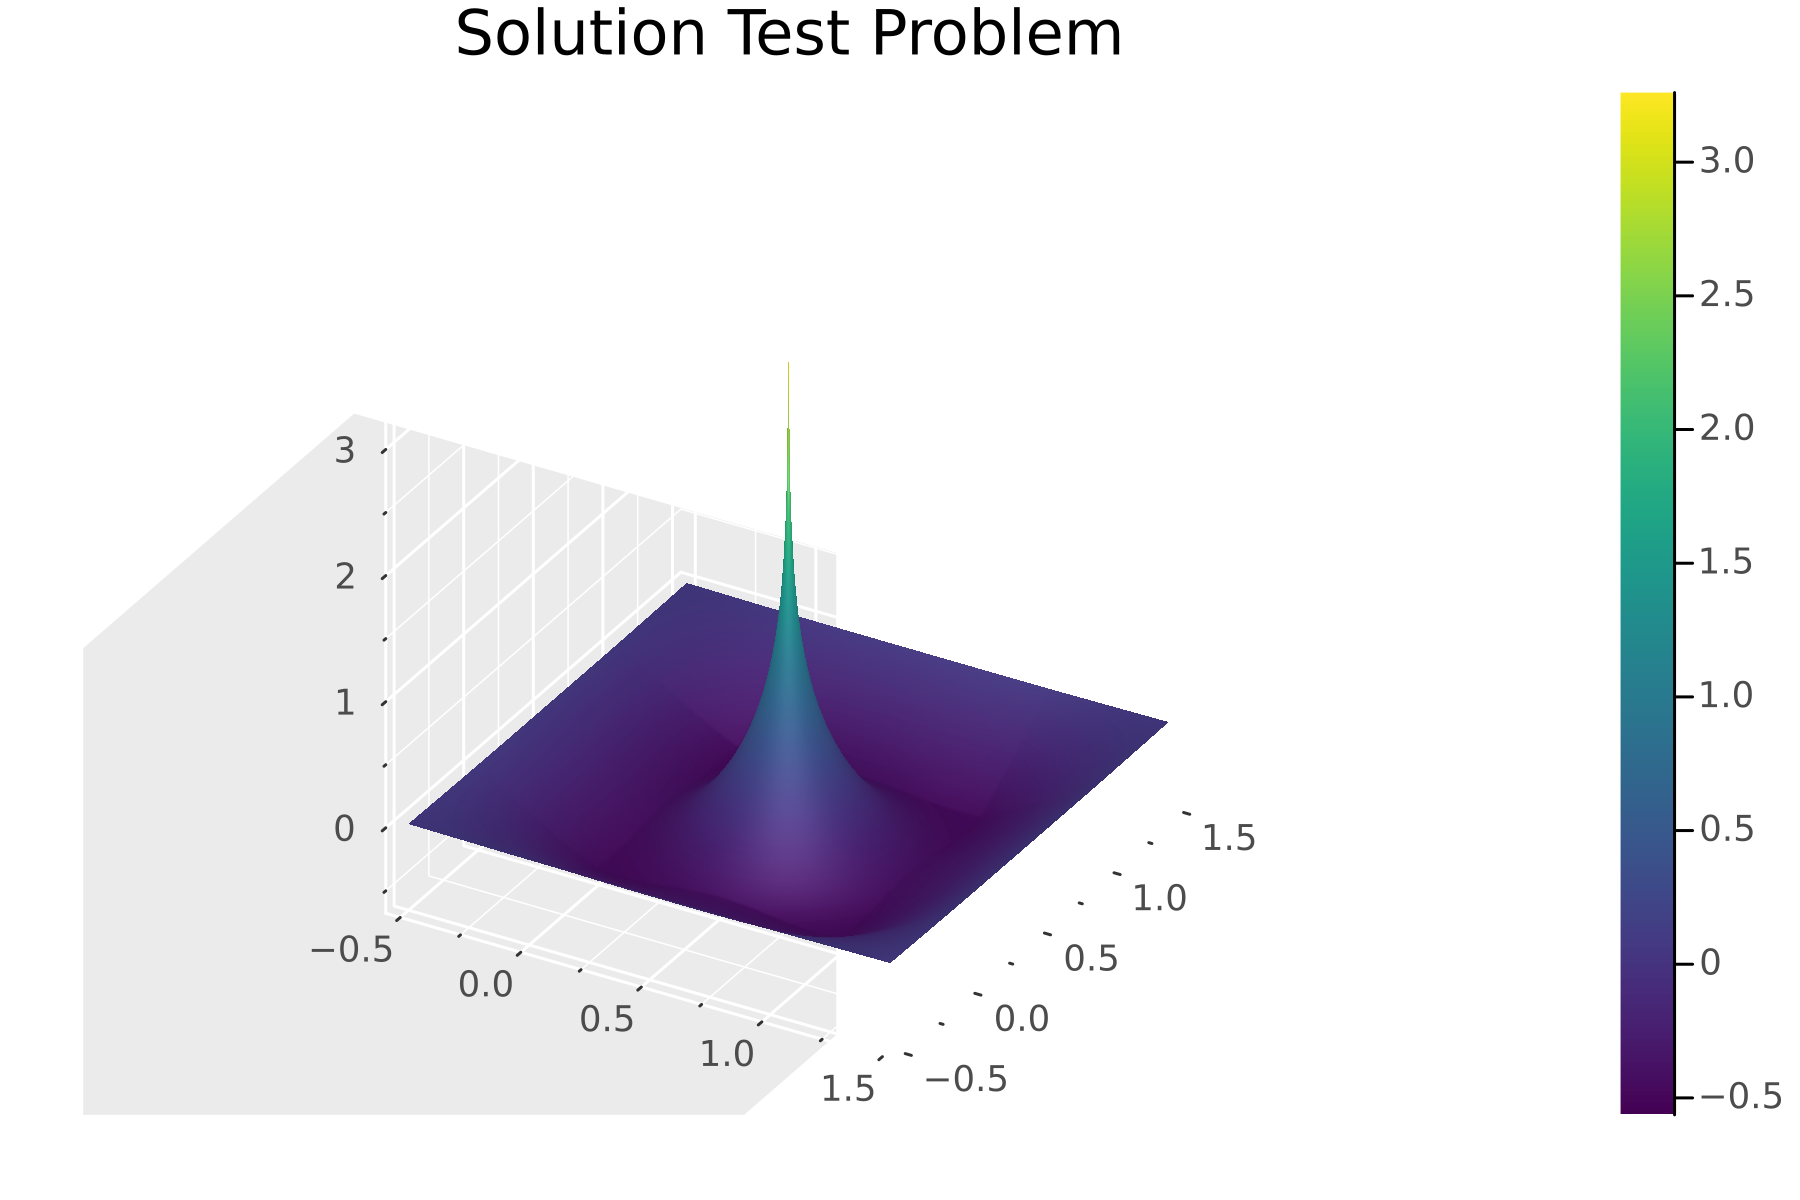

In [13]:
using Plots

# Set the plot size and dpi
default(size=(600,400), dpi=300)

x = y = range(-0.5, stop=1.5, length=2n-1)
z = reshape(real(u), 2n-1, 2n-1)
p = surface(x, y, z, color=:viridis, title="Solution Test Problem")

# Save the plot
savefig(p,"../plots/Solution_Test_Problem.png")
display(p)

# Shifted test problem

In [14]:
n = 2^7
grid,m = linspacecs(0,1,n+1,pi/6)
f = complex(float(pointsource_half2D(2*n)))
# f = wave_basis_2D(2*n,1,1) 
σ_bigger = float(-1000)
σ_shifted = σ_bigger*(1+1*im)
sigmas_bigger = spdiagm(σ_bigger*ones(length(grid)^2))
sigmas_shifted = spdiagm(σ_shifted*ones(length(grid)^2))
H_bigger = helmholtz2D(grid,sigmas_bigger);
H_shifted = helmholtz2D(grid,sigmas_shifted);
sol_bigger = H_bigger \ f;
sol_shifted = H_shifted \ f;

pre = nonuniform_preconditioner(; grid=grid, H=H_shifted, nu1=1,nu2=1);

In [15]:
errors_shifted = Float64[]
for i in 1:20
    u_shifted = nonUniformVcycle2D(
        grid=grid,
        A=H_shifted,
        f=f,
        u=u_shifted,
        nu1=1,
        nu2=1,
        recursion_depth=50)
    error = norm(sol_shifted - u_shifted)
    push!(errors_shifted, error)
    push!(us, u_shifted)
end

UndefVarError: UndefVarError: `u_shifted` not defined

In [16]:
theme(:ggplot2)
plot(errors_shifted, title="Error per V-cycle", label="error", xlabel="V-cycle", ylabel="Error",yscale=:log10)

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\isido\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\isido\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191


┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\isido\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\isido\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191


┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\isido\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191


┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\isido\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\isido\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191


In [17]:
S = Krylov.ktypeof(complex(float(f)))
global X = S[]  # Storage for GMRES iterates
gmres_callback(solver) = gmres_callbackX!(X,solver)

gmres_callback (generic function with 1 method)

In [18]:
X = S[]
presol, prestats = gmres(H_bigger, complex(float(f)), 
M=pre,
ldiv =false,
itmax = 100 ,
memory=500,
restart =true,
history=true,
callback =gmres_callback);
preres = [norm(H_bigger *x-f) for x in X];

In [19]:
X = S[]
nsol, nstats = gmres(H_bigger, complex(float(f)) ,itmax = 100 ,memory=500,restart =true,history=true,callback =gmres_callback);
nres = [norm(H_bigger *x-f) for x in X];

In [20]:
prestats

SimpleStats
 niter: 54
 solved: true
 inconsistent: false
 residuals: [ 7.4e+00  5.9e+00  4.4e+00 ...  2.3e-07  1.6e-07  1.1e-07 ]
 Aresiduals: []
 κ₂(A): []
 timer: 9.71s
 status: solution good enough given atol and rtol


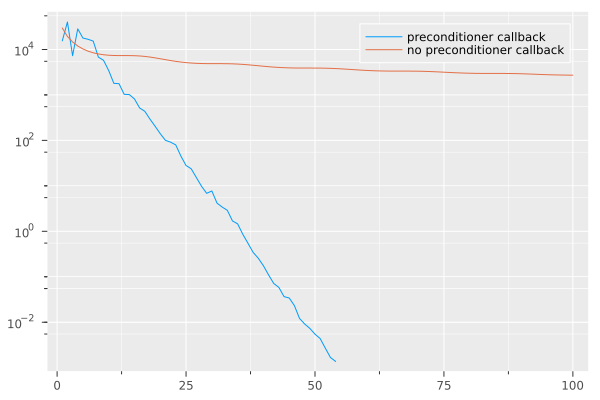

In [21]:
plot(preres, yscale =:log10, label="preconditioner callback")
plot!(nres, yscale =:log10, label="no preconditioner callback")